<a href="https://colab.research.google.com/github/lilyhuong/FinE/blob/master/Report_final_project_NGUYEN_Thi_Huong.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
!pip install gluonts

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 23.7 MB/s eta 0:00:00
  Attempting uninstall: pydantic
    Found existing installation: pydantic 2.1.1
    Uninstalling pydantic-2.1.1:
      Successfully uninstalled pydantic-2.1.1


In [4]:
!pip install "gluonts[mxnet]"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 12.7 MB/s eta 0:00:00
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.20.1
    Uninstalling graphviz-0.20.1:
      Successfully uninstalled graphviz-0.20.1


In [5]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 5.6 MB/s eta 0:00:00


In [6]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf
from pandas import read_csv
from matplotlib import pyplot
import pmdarima as pm
from pmdarima.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor

In [7]:
try:
    from google.colab import drive
    COLAB = True
    print("Note: using Google CoLab")
    %tensorflow_version 2.x
except:
    print("Note: not using Google CoLab")
    COLAB = False

Note: using Google CoLab
Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
os.chdir('/content/drive/MyDrive/magistere 3/')
path_images = "/content/drive/MyDrive/magistere 3/Mémoire fin d'étude/Data/data HDD europe.xlsx"

In [10]:
df = pd.read_excel(path_images, header = 0)


# Import data and cleaning data

In [11]:
# delete all columns that I dont want to use
df = df.drop(['Unit', 'Source Code', 'Source Wording', 'Note'], axis=1)

In [12]:
df.dropna(axis=1, how = 'all')

,Unnamed: 0,2011,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,...,Unnamed: 141,Unnamed: 142,Unnamed: 143,Unnamed: 144,Unnamed: 145,2023,Unnamed: 147,Unnamed: 148,Unnamed: 149,Unnamed: 150
0,NaN,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,...,Aug,Sep,Oct,Nov,Dec,Jan,Feb,Mar,Apr,May
1,Heating degree days,423,369,301,138,88,39,36,24,50,...,11,87,113,271,397,n.a.,n.a.,n.a.,n.a.,n.a.
2,Cooling degree days,0.05,0,0,5.25,18.74,45.56,59.05,73.9,41.11,...,117.52,36.45,9.5,0.74,0.02,n.a.,n.a.,n.a.,n.a.,n.a.
3,Net electricity consumption,255910,231708,238319,202572,204460,199330,207367,202373,206053,...,195744.016,189375.178,191494.594,200189.56,216143.673,223578.626,205318.184,n.a.,n.a.,n.a.


In [13]:
df = df.loc[:, ~(df == 'n.a.').any()]

In [14]:
df.columns = df.columns.map(str)

In [15]:
year = 2011
for column_index in range(1, 145):
  df.iat[0, column_index] = df.iat[0, column_index] + '/' + str(year)
  if column_index % 12 == 0:
    year += 1

df.iat[0, 0] = "date"

In [16]:
df.columns = df.iloc[0]

In [17]:
df.drop(index=0, inplace=True)

In [18]:
df2 = pd.melt(df,id_vars='date', value_vars=df.columns[1:].to_list())

In [19]:
df_final = df2.pivot_table(index= 0, columns='date', values='value', aggfunc='first').reset_index()

In [20]:
df_final.columns

Index([0, 'Cooling degree days', 'Heating degree days',
       'Net electricity consumption'],
      dtype='object', name='date')

In [21]:
df_final = df_final.rename(columns={df_final.columns[0]: 'Date'})

In [22]:
df_final['date_num'] = pd.to_datetime(df_final['Date'], format='%b/%Y').dt.to_period('M')

In [23]:
df_final = df_final.sort_values(by='date_num')

**Create variable month with interval between [0, 1)**

In [24]:
df_final['month'] = (df_final['date_num'].dt.month - 1) / 12

**Create summmer variable to define 2 season in Europe: summer = 1 if this month from april to october, summer = 0 if else**

In [25]:
df_final['summer'] = np.where((df_final['date_num'].dt.month <= 10) & (df_final['date_num'].dt.month >= 4), 1, 0)

# Data description

In [26]:
df_final.groupby('summer')["Net electricity consumption"].describe()

,count,mean,std,min,25%,50%,75%,max
summer,,,,,,,,
0,60.0,230482.580700,11768.826838,200189.560,222362.79975,229982.0,238514.00000,255910.0
1,84.0,201849.064762,7360.489110,176120.882,198549.77750,201374.5,206735.33475,218276.0


In [27]:
df_final.describe()

date,Cooling degree days,Heating degree days,Net electricity consumption,month,summer
count,144.000000,144.000000,144.000000,144.000000,144.000000
mean,25.003056,197.062500,213779.696403,0.458333,0.583333
std,34.866348,147.285519,17007.654476,0.288675,0.494727
min,0.000000,11.000000,176120.882000,0.000000,0.000000
25%,0.020000,49.000000,200647.378750,0.229167,0.000000
50%,4.170000,176.500000,209050.815500,0.458333,1.000000
75%,42.597500,318.250000,225389.500000,0.687500,1.000000
max,124.110000,489.000000,255910.000000,0.916667,1.000000


In [28]:
df_TS = df_final[["date_num", "Net electricity consumption"]]
#set up index to datetime type
df_TS.set_index('date_num', inplace=True)

<Axes: xlabel='date_num'>

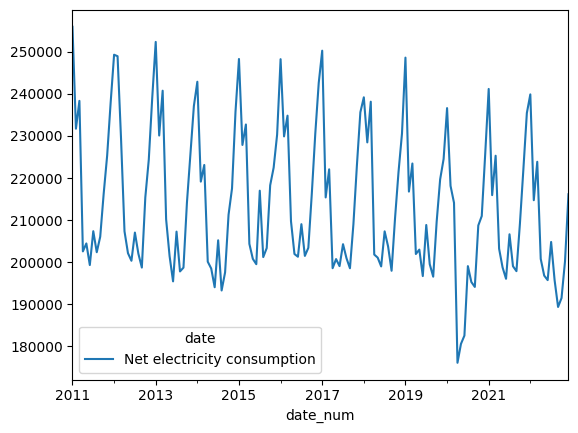

In [29]:
df_TS.plot()

In [30]:
df_TS.interpolate(inplace = True)
df_TS.index=df_TS.index.to_timestamp()

<ipython-input-30-ced2d31e58f6>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_TS.interpolate(inplace = True)


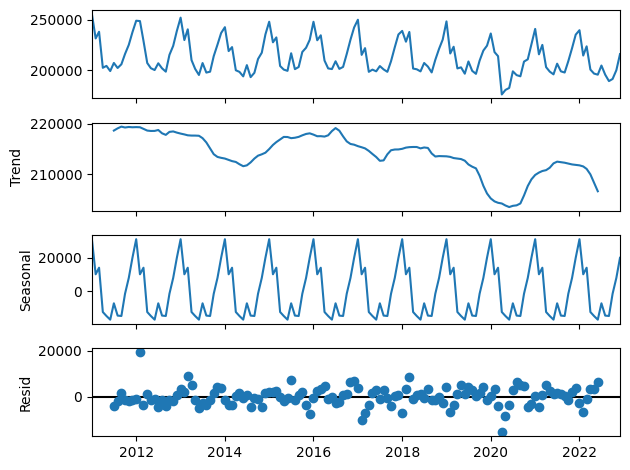

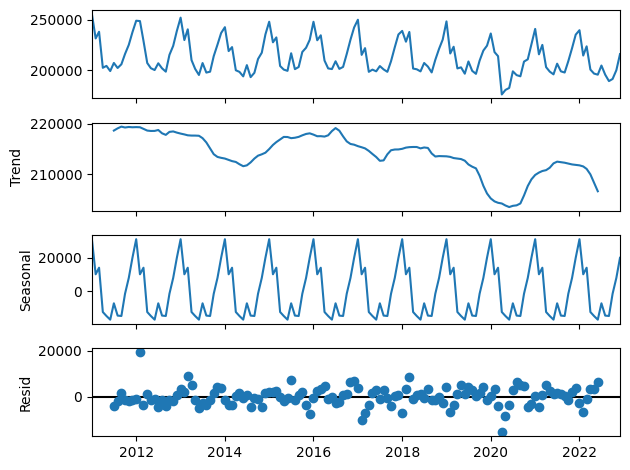

In [31]:
result = seasonal_decompose(df_TS)
result.plot()

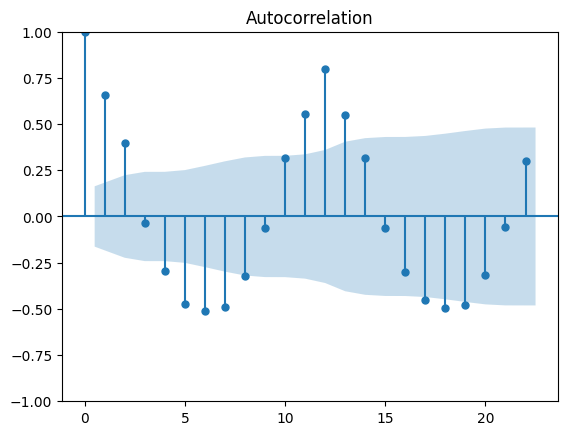

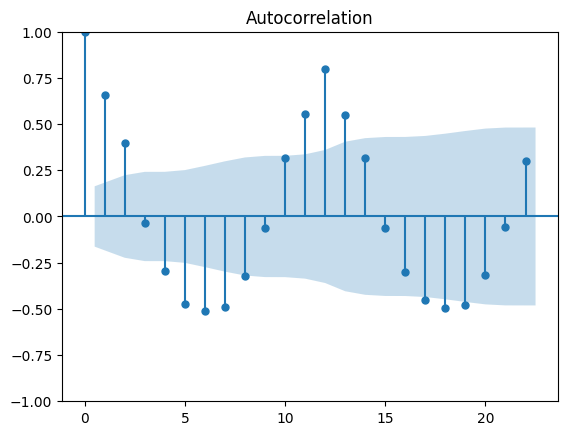

In [32]:
plot_acf(df_TS)

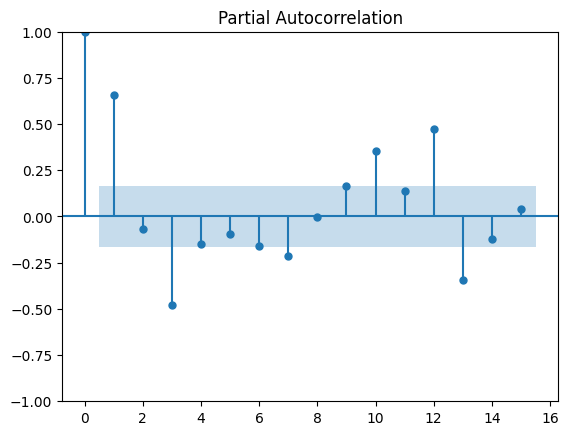

In [33]:
plot_pacf(df_TS, lags = 15)
pyplot.show()

In [35]:
import seaborn as sns
from  scipy.stats import skew, kurtosis, shapiro

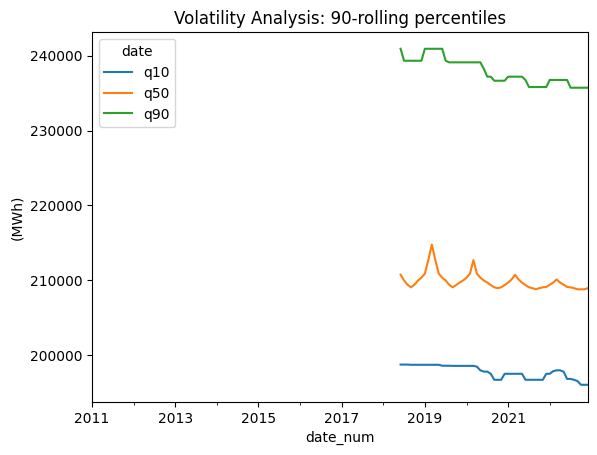

In [42]:
# Insert the rolling quantiles to the monthly returns
analyse = df_final.copy()
analyse = analyse.set_index('date_num', drop=False)
data_rolling = analyse["Net electricity consumption"].rolling(window=90)
analyse['q10'] = data_rolling.quantile(0.1).to_frame("q10")
analyse['q50'] = data_rolling.quantile(0.5).to_frame("q50")
analyse['q90'] = data_rolling.quantile(0.9).to_frame("q90")

analyse[["q10", "q50", "q90"]].plot(title="Volatility Analysis: 90-rolling percentiles")
plt.ylabel("(MWh)")
plt.show()

In [39]:
mean = np.mean(analyse["Net electricity consumption"].values)
std = np.std(analyse["Net electricity consumption"].values)


<ipython-input-40-6be5f99bfa2e>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(analyse["Net electricity consumption"])


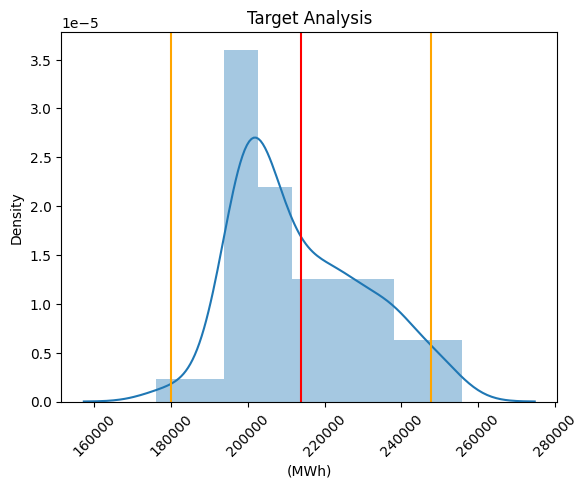

In [40]:
sns.distplot(analyse["Net electricity consumption"])
plt.title("Target Analysis")
plt.xticks(rotation=45)
plt.xlabel("(MWh)")
plt.axvline(x=mean, color='r', linestyle='-', label="\mu: {0:.2f}%".format(mean))
plt.axvline(x=mean+2*std, color='orange', linestyle='-')
plt.axvline(x=mean-2*std, color='orange', linestyle='-')
plt.show()

<Figure size 2000x1600 with 0 Axes>

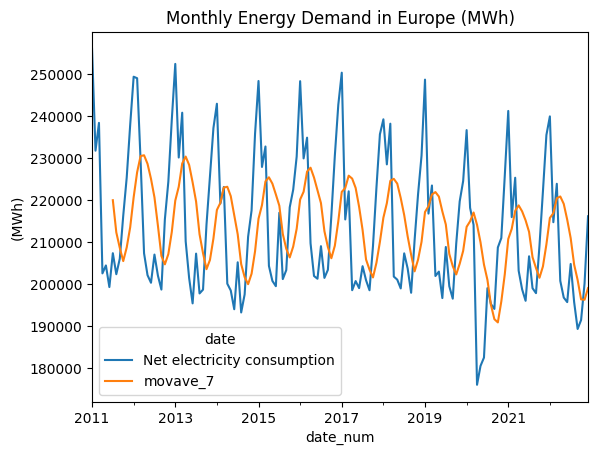

In [43]:
analyse["year"] = analyse.index.year
analyse["qtr"] = analyse.index.quarter
analyse["mon"] = analyse.index.month
analyse["week"] = analyse.index.week
analyse["day"] = analyse.index.weekday
analyse["ix"] = range(0,len(analyse))
analyse[["movave_7", "movstd_7"]] = analyse["Net electricity consumption"].rolling(7).agg([np.mean, np.std])
analyse[["movave_30", "movstd_30"]] = analyse["Net electricity consumption"].rolling(30).agg([np.mean, np.std])
analyse[["movave_90", "movstd_90"]] = analyse["Net electricity consumption"].rolling(90).agg([np.mean, np.std])

plt.figure(figsize=(20,16))
analyse[["Net electricity consumption", "movave_7"]].plot(title="Monthly Energy Demand in Europe (MWh)")
plt.ylabel("(MWh)")
plt.show()

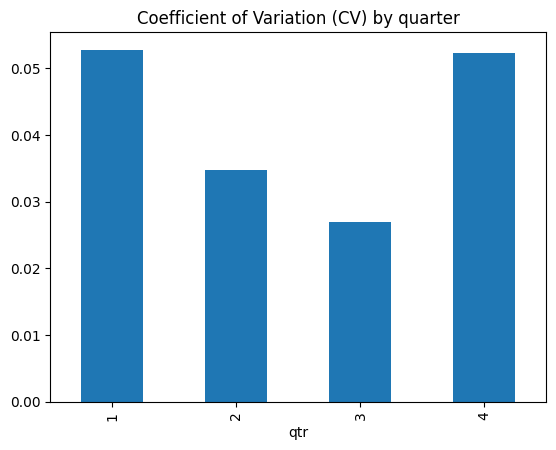

In [44]:
analyse.groupby("qtr")["Net electricity consumption"].std().divide(analyse.groupby("qtr")["Net electricity consumption"].mean()).plot(kind="bar")
plt.title("Coefficient of Variation (CV) by quarter")
plt.show()

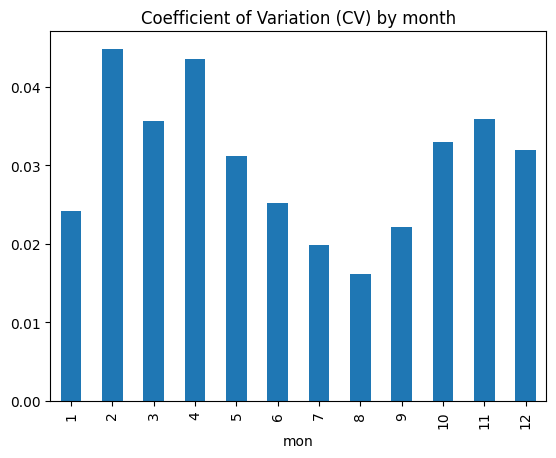

In [45]:
analyse.groupby("mon")["Net electricity consumption"].std().divide(analyse.groupby("mon")["Net electricity consumption"].mean()).plot(kind="bar")
plt.title("Coefficient of Variation (CV) by month")
plt.show()

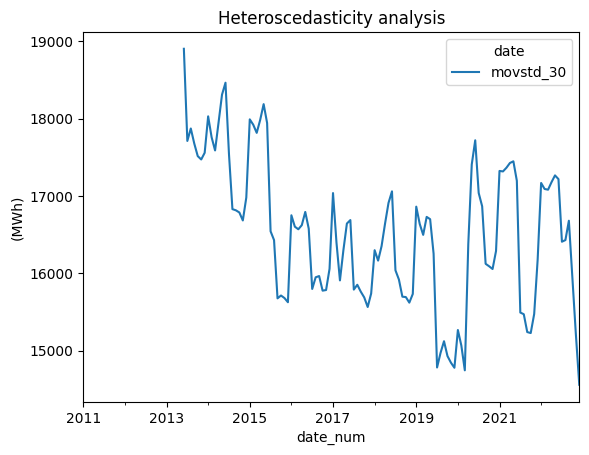

In [47]:
analyse[["movstd_30"]].plot(title="Heteroscedasticity analysis")
plt.ylabel("(MWh)")
plt.show()

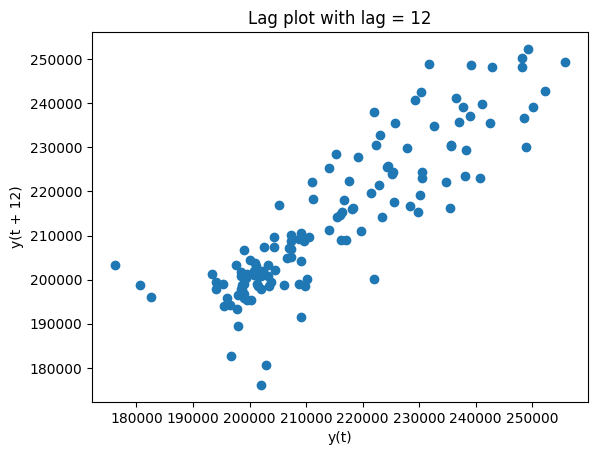

In [136]:
pd.plotting.lag_plot(df_TS, lag=12)
plt.title("Lag plot with lag = 12");
plt.show(block=True);

In [137]:
adf, pval, usedlag, nobs, crit_vals, icbest =  adfuller(df_TS["Net electricity consumption"].values)
print('ADF test statistic:', adf)
print('ADF p-values:', pval)
print('ADF number of lags used:', usedlag)
print('ADF number of observations:', nobs)
print('ADF critical values:', crit_vals)
print('ADF best information criterion:', icbest)

ADF test statistic: -1.1383576422825357
ADF p-values: 0.6995355410133098
ADF number of lags used: 12
ADF number of observations: 131
ADF critical values: {'1%': -3.481281802271349, '5%': -2.883867891664528, '10%': -2.5786771965503177}
ADF best information criterion: 2647.783563796369


Analyse result of Dickey Fuller test: Since the p-value is not less than .05, we fail to reject the null hypothesis.

This means the time series is non-stationary. In other words, it has some time-dependent structure and does not have constant variance over time.


<Axes: xlabel='date_num'>

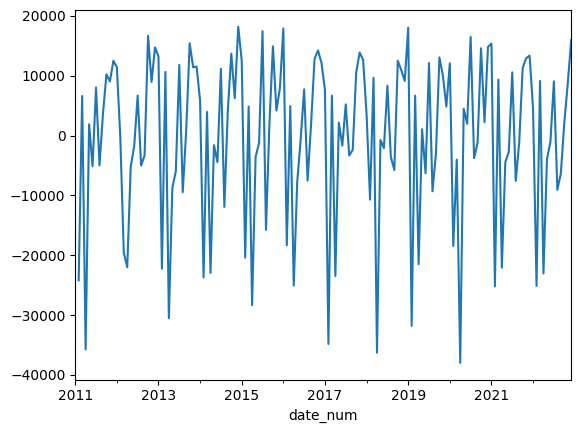

In [138]:
prev_value = df_TS["Net electricity consumption"].shift()
differenced = df_TS["Net electricity consumption"] - prev_value
differenced.plot()

In [139]:
adf, pval, usedlag, nobs, crit_vals, icbest =  adfuller(differenced.dropna())
print('ADF test statistic:', adf)
print('ADF p-values:', pval)
print('ADF number of lags used:', usedlag)
print('ADF number of observations:', nobs)
print('ADF critical values:', crit_vals)
print('ADF best information criterion:', icbest)

ADF test statistic: -5.862822661669426
ADF p-values: 3.379009271610905e-07
ADF number of lags used: 11
ADF number of observations: 131
ADF critical values: {'1%': -3.481281802271349, '5%': -2.883867891664528, '10%': -2.5786771965503177}
ADF best information criterion: 2627.6281799033104


The p-value is very small, indicating that the alternative hypothesis (stationarity) is true.

In [140]:
df_final.dtypes

date
Date                              object
Cooling degree days              float64
Heating degree days              float64
Net electricity consumption      float64
date_num                       period[M]
month                            float64
summer                             int64
dtype: object

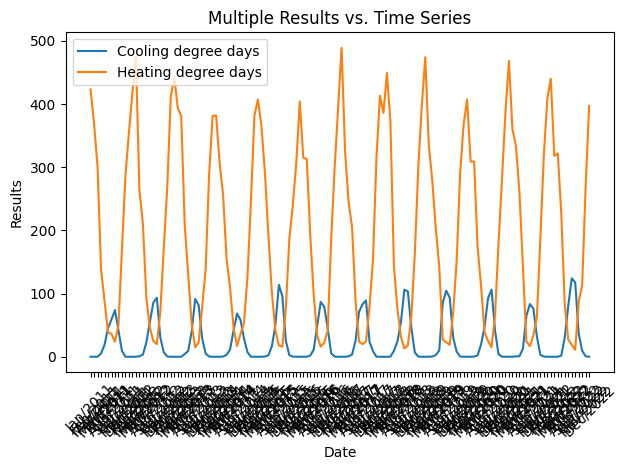

In [141]:
# Create a new figure and axis
fig, ax = plt.subplots()

# Plot multiple lines on the same graph

ax.plot(df_final["Date"], df_final["Cooling degree days"], label='Cooling degree days')
ax.plot(df_final["Date"], df_final["Heating degree days"], label='Heating degree days')

# Set labels and title
ax.set_xlabel('Date')
ax.set_ylabel('Results')
ax.set_title('Multiple Results vs. Time Series')

# Show the legend
ax.legend()

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Display the plot
plt.tight_layout()
plt.show()

# Feature Engineering

In [142]:
# change column name to easier for using
df_final = df_final.rename(columns={"Net electricity consumption": "elec", "Cooling degree days": "CDD", "Heating degree days":"HDD"})

**create variable lag net electricity consumption**

In [143]:
#create variable lag net electricity consumption
df_final["elec_lag1"] = df_final.elec.shift(1)
df_final["elec_lag12"] = df_final.elec.shift(12)
df_final = df_final.dropna(subset=['elec_lag12'])

In [144]:
df_final = df_final.reset_index().drop(columns=['index'])

In [145]:
# create rolling window mean bases on thg lag value
df_final['RollingElec'] = np.where((df_final['date_num'].dt.month).isin([2,3,7,8,9,10]), df_final.elec_lag1.rolling(3).mean(), np.nan)
df_final['RollingElec'] = np.where((df_final['date_num'].dt.month).isin([1, 6]), df_final.elec_lag1.rolling(2).mean(), df_final['RollingElec'])
df_final['RollingElec'] = np.where((df_final['date_num'].dt.month).isin([5, 12]), df_final.elec_lag1, df_final['RollingElec'])
df_final['RollingElec'] = np.where((df_final['date_num'].dt.month).isin([4, 11]), df_final.elec_lag12, df_final['RollingElec'])

In [146]:
df_final = df_final.dropna(subset=['RollingElec']).reset_index()

In [147]:
# the final dataframe
df_final

date,index,Date,CDD,HDD,elec,date_num,month,summer,elec_lag1,elec_lag12,RollingElec
0,2,Mar/2012,0.81,264.0,229357.000,2012-03,0.166667,0,248920.000,238319.000,245339.666667
1,3,Apr/2012,3.38,211.0,207344.000,2012-04,0.250000,1,229357.000,202572.000,202572.000000
2,4,May/2012,22.77,93.0,202150.000,2012-05,0.333333,1,207344.000,204460.000,207344.000000
3,5,Jun/2012,55.31,46.0,200347.000,2012-06,0.416667,1,202150.000,199330.000,204747.000000
4,6,Jul/2012,85.66,25.0,207039.000,2012-07,0.500000,1,200347.000,207367.000,203280.333333
...,...,...,...,...,...,...,...,...,...,...,...
125,127,Aug/2022,117.52,11.0,195744.016,2022-08,0.583333,1,204811.526,199054.298,199130.568000
126,128,Sep/2022,36.45,87.0,189375.178,2022-09,0.666667,1,195744.016,197878.682,198769.472333
127,129,Oct/2022,9.50,113.0,191494.594,2022-10,0.750000,1,189375.178,209142.343,196643.573333
128,130,Nov/2022,0.74,271.0,200189.560,2022-11,0.833333,0,191494.594,222074.199,222074.199000


# Machine Learning

In [148]:
def wmape(y_true, y_pred):
    return np.abs(y_true - y_pred).sum() / np.abs(y_true).sum()

In [149]:
from sklearn.model_selection import train_test_split

In [150]:
y = df_final["elec"]
X = df_final.drop(['index', "Date", "date_num", "elec","elec_lag1"], axis=1)

In [151]:
# train validation split
x_train, x_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.2, random_state=42, shuffle = False)

In [152]:
x_train

date,CDD,HDD,month,summer,elec_lag12,RollingElec
0,0.81,264.0,0.166667,0,238319.000,245339.666667
1,3.38,211.0,0.250000,1,202572.000,202572.000000
2,22.77,93.0,0.333333,1,204460.000,207344.000000
3,55.31,46.0,0.416667,1,199330.000,204747.000000
4,85.66,25.0,0.500000,1,207367.000,203280.333333
...,...,...,...,...,...,...
99,47.51,39.0,0.416667,1,196711.283,178359.721000
100,92.74,25.0,0.500000,1,208842.652,179765.998000
101,106.26,15.0,0.583333,1,199533.489,187415.540333
102,41.61,65.0,0.666667,1,196574.783,192315.450000


Total number of observations:  130
Train: (104, 6)(104,), 
Test: (26, 6)(26,)


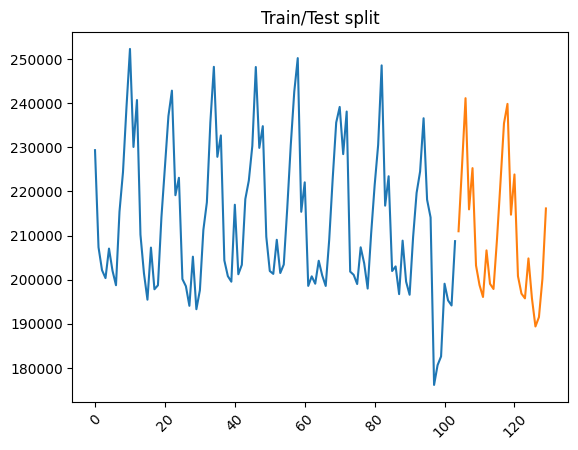

In [153]:
nobs= len(df_final)
n, k = x_train.shape
print("Total number of observations: ", nobs)
print("Train: {}{}, \nTest: {}{}".format(x_train.shape, y_train.shape,
                                              x_valid.shape, y_valid.shape))

plt.plot(y_train.index, y_train.values, label="train")
plt.plot(y_valid.index, y_valid.values, label="test")
plt.title("Train/Test split")
plt.xticks(rotation=45)
plt.show()

In [154]:
from pandas.core.common import random_state
linear = LinearRegression(fit_intercept = True).fit(x_train, y_train)
# get score accuracy of model
linear.score(x_valid, y_valid)

0.7321928151899928

In [155]:
from sklearn.metrics import mean_squared_error

In [156]:
p_train = linear.predict(x_train)
p_test = linear.predict(x_valid)

RMSE_train = np.sqrt(mean_squared_error(y_train, p_train))
RMSE_test = np.sqrt(mean_squared_error(y_valid, p_test))

print("Train RMSE: {}\nTest RMSE: {}".format(RMSE_train, RMSE_test) )

Train RMSE: 5537.518435672553
Test RMSE: 7612.248561483096


In [157]:
print("wmape", wmape(y_valid, p_test))

wmape 0.027935378411041805


In [158]:
neural = MLPRegressor( max_iter = 500).fit(x_train, y_train)
#get the score accuracy of model
neural.score(x_valid, y_valid)

0.526482353468366

In [159]:
p_train = neural.predict(x_train)
p_test = neural.predict(x_valid)

RMSE_train = np.sqrt(mean_squared_error(y_train, p_train))
RMSE_test = np.sqrt(mean_squared_error(y_valid, p_test))

print("Train RMSE: {}\nTest RMSE: {}".format(RMSE_train, RMSE_test) )

Train RMSE: 8400.994137189575
Test RMSE: 10122.083903221837


In [160]:
print("wmape", wmape(y_valid, p_test))

wmape 0.03648828748667019


TRAIN: 26 TEST: 26


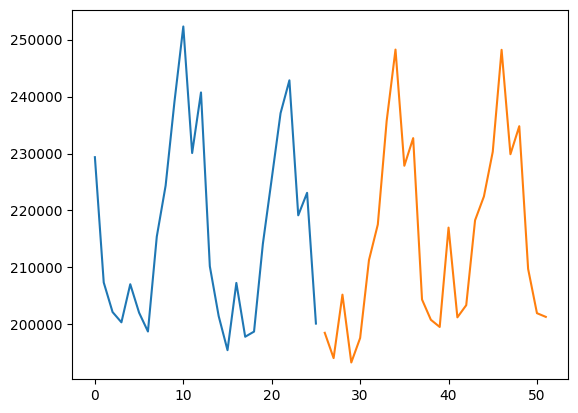

TRAIN: 52 TEST: 26


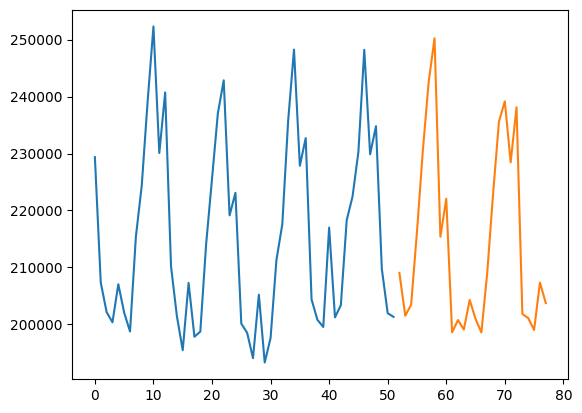

TRAIN: 78 TEST: 26


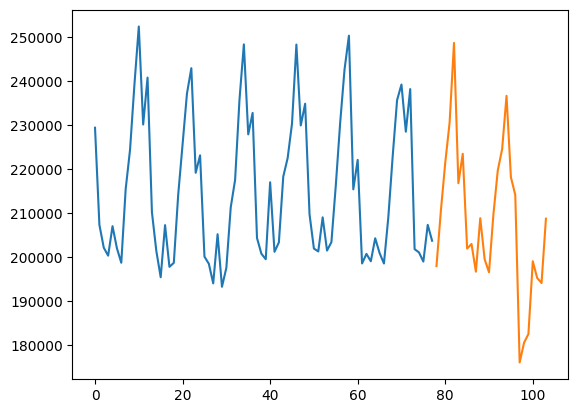

In [161]:
from sklearn.model_selection import TimeSeriesSplit, ParameterGrid

splits = TimeSeriesSplit(n_splits=3, max_train_size=365*2)
for train_index, val_index in splits.split(x_train):
    print("TRAIN:", len(train_index), "TEST:", len(val_index))
    y_train[train_index].plot()
    y_train[val_index].plot()
    plt.show()

In [162]:
from sklearn.ensemble import RandomForestRegressor

splits = TimeSeriesSplit(n_splits=3, max_train_size=365*2)
rfr = RandomForestRegressor()
# Create a dictionary of hyperparameters to search
rfr_grid = {"n_estimators": [500],
        'max_depth': [3, 5, 10, 20, 30],
        'max_features': [4, 8, 16, 32, 59],
        'random_state': [123]}
rfr_paramGrid = ParameterGrid(rfr_grid)

def TimeSplit_ModBuild(model, paramGrid, splits, X, y):
    from sklearn.model_selection import TimeSeriesSplit
    from sklearn.metrics import mean_squared_error

    #Loop over each time split and for each
    for train_index, val_index in splits.split(x_train):
        _X_train_ = X.iloc[train_index]
        _y_train_ = y.iloc[train_index]
        _X_val_ = X.iloc[val_index]
        _y_val_ = y.iloc[val_index]

        train_scores = []
        val_scores = []
        #models = []

        # Loop through the parameter grid, set the hyperparameters, and save the scores
        for g in paramGrid:
            model.set_params(**g)
            model.fit(_X_train_, _y_train_)
            p_train = model.predict(_X_train_)
            p_val = model.predict(_X_val_)
            score_train = np.mean(mean_squared_error(_y_train_, p_train))
            score_val = np.mean(mean_squared_error(_y_val_, p_val))
            train_scores.append(score_train)
            val_scores.append(score_val)
            #models.append(model)
            best_idx = np.argmin(val_scores)

        print("Best-Fold HyperParams:: ", paramGrid[best_idx])
        print("Best-Fold Train RMSE: ", train_scores[best_idx])
        print("Best-Fold Val RMSE: ",val_scores[best_idx])
        print("\n")

    #Return most recent model
    return train_scores, val_scores, best_idx


CV_rfr_tup = TimeSplit_ModBuild(rfr, rfr_paramGrid, splits, x_train, y_train)

Best-Fold HyperParams::  {'random_state': 123, 'n_estimators': 500, 'max_features': 4, 'max_depth': 3}
Best-Fold Train RMSE:  9291467.256602906
Best-Fold Val RMSE:  30793627.22387186


Best-Fold HyperParams::  {'random_state': 123, 'n_estimators': 500, 'max_features': 4, 'max_depth': 10}
Best-Fold Train RMSE:  3714443.2036100915
Best-Fold Val RMSE:  22595565.487079486


Best-Fold HyperParams::  {'random_state': 123, 'n_estimators': 500, 'max_features': 8, 'max_depth': 3}
Best-Fold Train RMSE:  12729153.916176442
Best-Fold Val RMSE:  81533556.45055531




In [163]:
best_rfr_idx = CV_rfr_tup[2]
best_rfr_grid = rfr_paramGrid[best_rfr_idx]
best_rfr = RandomForestRegressor().set_params(**best_rfr_grid).\
    fit(x_train, y_train)

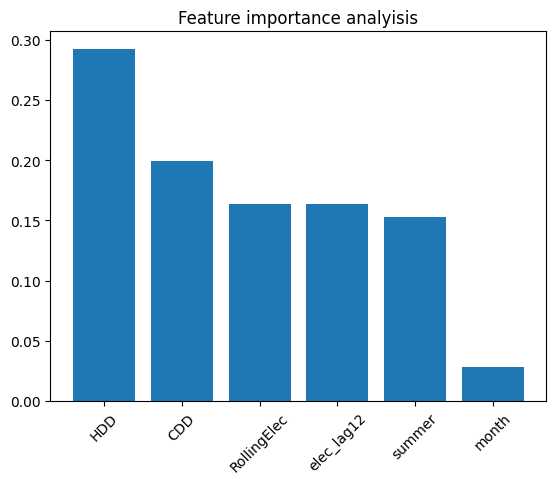

In [164]:
# Get feature importances from our random forest model
importances = best_rfr.feature_importances_

# Get the index of importances from greatest importance to least
sorted_index = np.argsort(importances)[::-1]
sorted_index_top = sorted_index[:10]
x = range(len(sorted_index_top))

# Create tick labels
labels = np.array(X.columns)[sorted_index_top]
plt.bar(x, importances[sorted_index_top], tick_label=labels)
plt.title("Feature importance analyisis")
# Rotate tick labels to vertical
plt.xticks(rotation=45)
plt.show()

In [165]:
mean = np.mean(df_final.elec.values)
std = np.std(df_final.elec.values)

In [166]:
test_df = pd.DataFrame(y_valid*std+mean)

In [167]:
test_df = pd.DataFrame(y_valid*std+mean)
test_df["pred"] = p_test*std+mean
test_df["resid"] = test_df["elec"].add(-test_df["pred"])
test_df["abs_resid"] = abs(test_df["resid"])
test_df["ape"] = test_df["resid"].div(test_df["elec"])

test_MAPE = test_df["ape"].mean()*100
print("1-period ahead forecasting MAPE: ", test_MAPE)

1-period ahead forecasting MAPE:  -1.6101743390474894


In [168]:
test_df['index'] = test_df.index

In [169]:
df_final["index"] = df_final["index"] - 2

In [170]:
compare = test_df.merge(df_final, how='left', on='index')[["date_num", "elec_x", "pred"]]

In [171]:
print("wmape", wmape(compare['elec_x'], compare['pred']))

wmape 0.03648602252197201


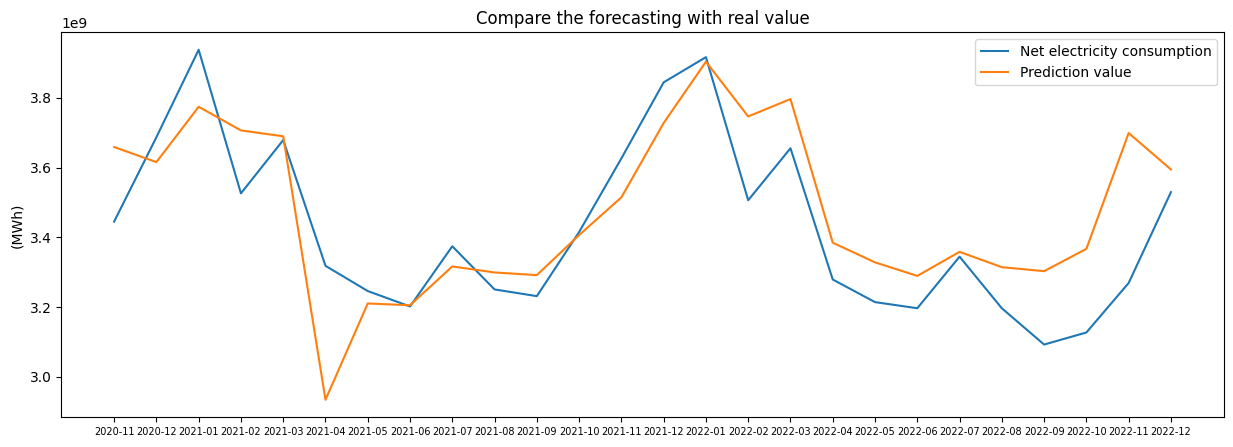

In [172]:

compare[["elec_x", "pred"]].plot(figsize=(15,5))

plt.title("Compare the forecasting with real value")
plt.xticks(compare.index, compare["date_num"].values, fontsize=7)
plt.ylabel("(MWh)")
plt.legend(['Net electricity consumption', 'Prediction value'])

plt.show()

## DeepAR

In [173]:
from gluonts.dataset.pandas import PandasDataset
import matplotlib.pyplot as plt
import torch
import mxnet as mx
from gluonts.mx import DeepAREstimator
from gluonts.mx.trainer import Trainer
from gluonts.dataset.common import ListDataset
from gluonts.dataset.field_names import FieldName
import seaborn as sns
from gluonts.mx.distribution.student_t import StudentTOutput
from gluonts.evaluation import make_evaluation_predictions
from gluonts.evaluation import Evaluator
from sklearn.model_selection import ParameterGrid

In [174]:
df_ar = df_final.copy()
# df_ar['date_num'] = pd.to_datetime(df_ar.date_num, format='%Y/%m')
df_ar = df_ar.set_index('date_num', drop=False)
df_ar = df_ar.drop(['index', "Date", "date_num","elec_lag1"], axis=1)

In [175]:
train = df_ar.loc[(df_ar.index <= "2020-10")]
test = df_ar.loc[(df_ar.index > "2020-10")]

In [176]:
training_data = ListDataset(
    [
      {"start": train.index[0],
      "target": train.elec,
      'feat_dynamic_real': [train.CDD, train.HDD, train.month, train.summer, train.elec_lag12, train.RollingElec]
      }
      ],
    freq="Y"
)

training_data2 = ListDataset(
    [
      {"start": train.index[0],
      "target": train.elec,
      'feat_dynamic_real': [df_ar.CDD, df_ar.HDD, df_ar.month, df_ar.summer, df_ar.elec_lag12, df_ar.RollingElec]
      }
      ],
    freq="Y"
)

test_data = ListDataset(
    [
        {"start": df_ar.index[0],
        "target": df_ar.elec,
        'feat_dynamic_real': [df_ar.CDD, df_ar.HDD, df_ar.month, df_ar.summer, df_ar.elec_lag12, df_ar.RollingElec]
        }
    ],
    freq="Y"
)


estimator_with_features = DeepAREstimator(
    freq= 'Y',
    prediction_length = len(test.index),
    context_length = 30,
    num_layers = 8,
    use_feat_dynamic_real = True,
    trainer= Trainer(epochs = 15, num_batches_per_epoch = 25),
)

predictor = estimator_with_features.train(training_data)

forecast_it, ts_it = make_evaluation_predictions(dataset= test_data, predictor=predictor)
evaluator = Evaluator(quantiles=(np.arange(20) / 20.0)[1:])
agg_metrics, item_metrics = evaluator(ts_it, forecast_it, num_series=len(test_data))

Running evaluation: 100%|██████████| 1/1 [00:01<00:00,  1.14s/it]


In [177]:
pred = list(predictor.predict(training_data2))
all_preds = list()
for item in pred:
    family = item.item_id
    p = item.samples.mean(axis=0)
    p10 = np.percentile(item.samples, 10, axis=0)
    p90 = np.percentile(item.samples, 90, axis=0)
    dates = pd.date_range(start='2020-11', periods=26, freq='M').to_period('M')
    family_pred = pd.DataFrame({'date_num': dates, 'pred': p, 'p10': p10, 'p90': p90})
    all_preds += [family_pred]
all_preds = pd.concat(all_preds, ignore_index=True)
all_preds = all_preds.merge(test, on=['date_num'], how='left')

print("wmape", wmape(all_preds['elec'], all_preds['pred']))
all_preds["diff"] = abs(1 - (all_preds["pred"]/all_preds["elec"]))

wmape 0.0786399961788611


In [178]:
all_preds

,date_num,pred,p10,p90,CDD,HDD,elec,month,summer,elec_lag12,RollingElec,diff
0,2020-11,195062.578125,177319.557812,212360.845312,0.11,281.0,210970.271,0.833333,0,219666.005,219666.005000,0.075403
1,2020-12,184981.453125,162209.559375,207259.348438,0.00,388.0,225791.121,0.916667,0,224512.523,210970.271000,0.180741
2,2021-01,183745.265625,168106.304688,202877.431250,0.01,468.0,241148.772,0.000000,0,236598.953,218380.696000,0.238042
3,2021-02,181319.312500,161835.701563,203136.635938,0.05,360.0,215930.365,0.083333,0,218132.386,225970.054667,0.160288
4,2021-03,185439.062500,170761.171875,202703.892188,0.64,334.0,225287.950,0.166667,0,214103.868,227623.419333,0.176880
5,2021-04,193581.078125,174351.275000,217387.800000,0.87,261.0,203204.950,0.250000,1,176120.882,176120.882000,0.047360
6,2021-05,190491.046875,178695.103125,204518.451563,12.63,142.0,198771.645,0.333333,1,180598.560,203204.950000,0.041659
7,2021-06,210691.062500,194410.887500,228160.151563,64.88,24.0,196062.424,0.416667,1,182578.552,200988.297500,0.074612
8,2021-07,210337.859375,191731.817188,226236.462500,83.35,17.0,206634.113,0.500000,1,199069.509,199346.339667,0.017924
9,2021-08,201203.578125,181063.481250,217116.400000,76.38,34.0,199054.298,0.583333,1,195298.289,200489.394000,0.010797


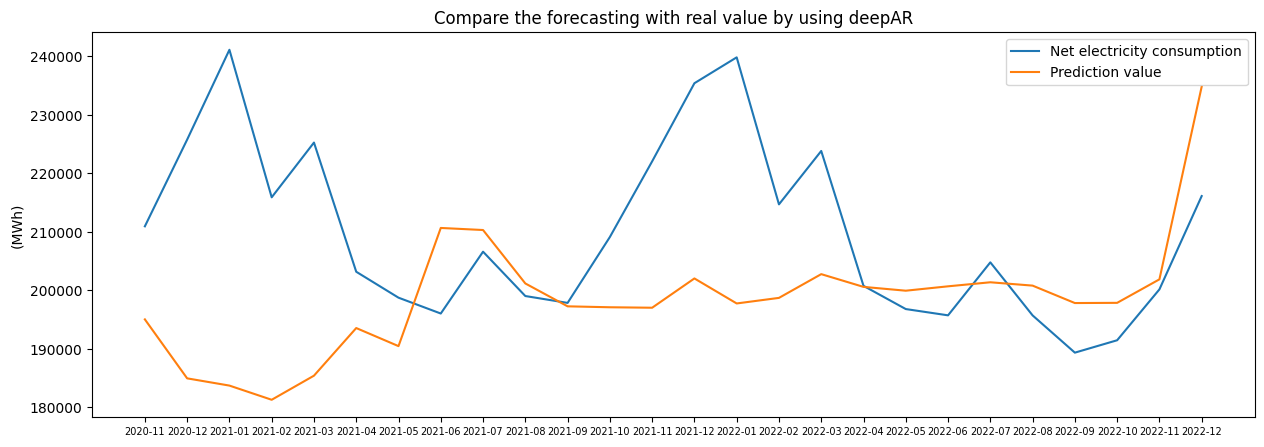

In [179]:
all_preds[["elec", "pred"]].plot(figsize=(15,5))

plt.title("Compare the forecasting with real value by using deepAR")
plt.xticks(all_preds.index, all_preds["date_num"].values, fontsize=7)
plt.ylabel("(MWh)")
plt.legend(['Net electricity consumption', 'Prediction value'])

plt.show()

# Estimation results with different minimum comfortable temperature

In [180]:
df_final2 = df_final.copy()

In [181]:
df_final2["CDD_20"] = df_final2["CDD"] - 2
df_final2["CDD_22"] = df_final2["CDD"] - 5
df_final2["HDD_20"] = df_final2["HDD"] + 2
df_final2["HDD_22"] = df_final2["HDD"] + 5

## For comfortable temperature  = 20

---



---



In [182]:
y = df_final2["elec"]
X = df_final2.drop(['index', "Date", "date_num", "elec","elec_lag1", "CDD","HDD", "CDD_22", "HDD_22"], axis=1)

In [183]:
# train validation split
x_train, x_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.2, random_state=42, shuffle = False)

In [184]:
linear2 = LinearRegression(fit_intercept = True).fit(x_train, y_train)
# get score accuracy of model
linear2.score(x_valid, y_valid)

0.7321928151896753

In [185]:
p_train = linear2.predict(x_train)
p_test = linear2.predict(x_valid)

RMSE_train = np.sqrt(mean_squared_error(y_train, p_train))
RMSE_test = np.sqrt(mean_squared_error(y_valid, p_test))

print("Train RMSE: {}\nTest RMSE: {}".format(RMSE_train, RMSE_test) )

Train RMSE: 5537.518435672553
Test RMSE: 7612.248561487609


In [186]:
print("wmape", wmape(y_valid, p_test))

wmape 0.027935378411042492


## For comfortable temperature  = 22

In [188]:
y = df_final2["elec"]
X = df_final2.drop(['index', "Date", "date_num", "elec","elec_lag1", "CDD","HDD", "CDD_20", "HDD_20"], axis=1)

In [189]:
# train validation split
x_train, x_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.2, random_state=42, shuffle = False)

In [190]:
linear3 = LinearRegression(fit_intercept = True).fit(x_train, y_train)
# get score accuracy of model
linear3.score(x_valid, y_valid)

0.7321928151890633

In [191]:
p_train = linear3.predict(x_train)
p_test = linear3.predict(x_valid)

RMSE_train = np.sqrt(mean_squared_error(y_train, p_train))
RMSE_test = np.sqrt(mean_squared_error(y_valid, p_test))

print("Train RMSE: {}\nTest RMSE: {}".format(RMSE_train, RMSE_test) )

Train RMSE: 5537.518435672551
Test RMSE: 7612.248561496307


In [192]:
print("wmape", wmape(y_valid, p_test))

wmape 0.027935378411080996
